# Gym Repetitions Counting

This notebook was created based ont Nicholas Rennet's video on [AI Pose estimation](https://www.youtube.com/watch?v=06TE_U21FK4) with Mediapipe, and modified to determine different kind of exercises using Computer Vision.

## 1. Base code

This is the base code presented by Nicholas, with which we can count repetitions of Biceps curls with the left hand. The counter increases by one whenever the left arm is in a "down state" (meaning that the angle conformed by the shoulder-elbow-wrist keypoints is above 160°) and then, the left arm changes its state to an "up state" (when this angle is below 30°).

In [2]:
# Imports
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('seaborn')

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
# Function for calculating angle between 3 points
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [5]:
cap = cv2.VideoCapture(0)

# Curl counter variables
counter = 0 
stage = None

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            
            # Calculate angle
            angle = calculate_angle(shoulder, elbow, wrist)
            
            # Visualize angle
            cv2.putText(image, str(angle), 
                           tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )
            
            # Curl counter logic
            if angle > 160:
                stage = "down"
            if angle < 30 and stage =='down':
                stage="up"
                counter +=1
                print(counter)
                       
        except:
            pass
        
        # Render curl counter
        # Setup status box
        cv2.rectangle(image, (0,0), (225,73), (245,117,16), -1)
        
        # Rep data
        cv2.putText(image, 'REPS', (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(counter), 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 2, cv2.LINE_AA)
        
        # Stage data
        cv2.putText(image, 'STAGE', (65,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, stage, 
                    (60,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


# 2. Some quick changes

As not all Biceps Curls exercises include such a big Range of Movement (RoM), I'm changing these state angles to set them between 40° and 90°. Also, I'm taking these angle calculation and the logic that is specific to Biceps Curl, outside the video detection and wrapping it in a function, so later we can use it for more diverse exercises.

### 2.1 Exercise counter


In [43]:
def get_coordinates(landmarks):
    
    # Head
    nose = [landmarks[mp_pose.PoseLandmark.NOSE.value].x, landmarks[mp_pose.PoseLandmark.NOSE.value].y]
    
    # Shoulders
    l_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
    r_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    
    # Elbows
    l_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
    r_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
    
    # Wrists
    l_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
    r_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
    
    # Hip
    l_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    r_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
      
    # Knees
    l_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
    r_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
    
    # Ankles
    l_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
    r_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
    
    return nose, l_shoulder, r_shoulder, l_elbow, r_elbow, l_wrist, r_wrist, l_hip, r_hip, l_knee, r_knee, l_ankle, r_ankle



def get_angles(l_shoulder, r_shoulder, l_elbow, r_elbow, l_wrist, r_wrist, l_hip, r_hip, l_knee, r_knee, l_ankle, r_ankle):
    
    # Elbow angles
    l_elbow_angle = calculate_angles(l_shoulder, l_elbow, l_wrist)
    r_elbow_angle = calculate_angles(r_shoulder, r_elbow, r_wrist)
    
    # Shoulder angles
    l_shoulder_angle = calculate_angles(l_hip, l_shoulder, l_elbow)
    r_shoulder_angle = calculate_angles(r_hip, r_shoulder, r_elbow)
    
    # Knee angles
    l_knee_angle = calculate_angles(l_hip, l_knee, l_ankle)
    r_knee_angle = calculate_angles(r_hip, r_knee, r_ankle)
    
    # Hip angles
    l_hip_angle = calculate_angles(l_shoulder, l_hip, l_ankle)
    r_hip_angle = calculate_angles(r_shoulder, r_hip, r_ankle)
    
    return l_elbow_angle, r_elbow_angle, l_shoulder_angle, r_shoulder_angle, l_knee_angle, r_knee_angle, l_hip_angle, r_hip_angle



def exercise_counter(exercise, landmark):
    
    # Get coordinates
    keypoints = get_coordinates(exercise)
    
    # Calculate angles
    angles = get_angles(keypoints)
    
    return None
    

In [80]:
cap = cv2.VideoCapture(0)

# Curl counter variables
counter = 0 
stage = None

# Lists for storing values
keypoints_list = []
angles_list = []

## Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
        
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            keypoints = get_coordinates(landmarks)
            keypoints_list.append(keypoints)
            
            # Calculate angle
            angles = get_angles(keypoints)
            angles_list.append(angles)
                       
        except:
            pass
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [81]:
len(keypoints_list)

112

In [82]:
keypoints = ['nose', 
             'l_shoulder', 'r_shoulder', 
             'l_elbow', 'r_elbow', 
             'l_wrist', 'r_wrist', 
             'l_hip', 'r_hip', 
             'l_knee', 'r_knee', 
             'l_ankle', 'r_ankle']

X_nose = []
X_l_shoulder = []
X_r_shoulder = []
X_l_elbow = []
X_r_elbow = []
X_l_wrist = []
X_r_wrist = []
X_l_hip = []
X_r_hip = []
X_l_knee = []
X_r_knee = []
X_l_ankle = []
X_r_ankle = []

Y_nose = []
Y_l_shoulder = []
Y_r_shoulder = []
Y_l_elbow = []
Y_r_elbow = []
Y_l_wrist = []
Y_r_wrist = []
Y_l_hip = []
Y_r_hip = []
Y_l_knee = []
Y_r_knee = []
Y_l_ankle = []
Y_r_ankle = []

for image in keypoints_list:
    
    # X values
    X_nose.append(image[0][0])
    X_l_shoulder.append(image[1][0])
    X_r_shoulder.append(image[2][0])
    X_l_elbow.append(image[3][0])
    X_r_elbow.append(image[4][0])
    X_l_wrist.append(image[5][0])
    X_r_wrist.append(image[6][0])
    X_l_hip.append(image[7][0])
    X_r_hip.append(image[8][0])
    X_l_knee.append(image[9][0])
    X_r_knee.append(image[10][0])
    X_l_ankle.append(image[11][0])
    X_r_ankle.append(image[12][0])
    
    # Y values
    Y_nose.append(image[0][1])
    Y_l_shoulder.append(image[1][1])
    Y_r_shoulder.append(image[2][1])
    Y_l_elbow.append(image[3][1])
    Y_r_elbow.append(image[4][1])
    Y_l_wrist.append(image[5][1])
    Y_r_wrist.append(image[6][1])
    Y_l_hip.append(image[7][1])
    Y_r_hip.append(image[8][1])
    Y_l_knee.append(image[9][1])
    Y_r_knee.append(image[10][1])
    Y_l_ankle.append(image[11][1])
    Y_r_ankle.append(image[12][1])



In [83]:
def show_plot(keypoints = ['all']):
    
    if 'all' in keypoints:
        
        #################### X AXIS ########################
        # Nose
        plt.plot(np.array(X_nose) - min(X_nose), c = 'yellow', label = 'X_nose')
        
        # Shoulders
        plt.plot(np.array(X_l_shoulder) - min(X_l_shoulder), c = 'r', label = 'X_shoulder (left)')
        plt.plot(np.array(X_r_shoulder) - min(X_r_shoulder), c = 'r', label = 'X_shoulder (right)')
        
        # Elbows
        plt.plot(np.array(X_l_elbow) - min(X_l_elbow), c = 'b', label = 'X_elbow (left)')
        plt.plot(np.array(X_r_elbow) - min(X_r_elbow), c = 'b', label = 'X_elbow (right)')
        
        # Wrists
        plt.plot(np.array(X_l_wrist) - min(X_l_wrist), c = 'k', label = 'X_wrist (left)')
        plt.plot(np.array(X_r_wrist) - min(X_r_wrist), c = 'k', label = 'X_wrist (right)')
        
        # Hips
        plt.plot(np.array(X_l_hip) - min(X_l_hip), c = 'orange', label = 'X_hip (left)')
        plt.plot(np.array(X_r_hip) - min(X_r_hip), c = 'orange', label = 'X_hip (right)')
        
        # Knees
        plt.plot(np.array(X_l_knee) - min(X_l_knee), c = 'purple', label = 'X_knee (left)')
        plt.plot(np.array(X_r_knee) - min(X_r_knee), c = 'purple', label = 'X_knee (right)')
        
        # Ankles
        plt.plot(np.array(X_l_ankle) - min(X_l_ankle), c = 'g', label = 'X_ankle (left)')
        plt.plot(np.array(X_r_ankle) - min(X_r_ankle), c = 'g', label = 'X_ankle (right)')
        
        # Plot settings
        plt.title("Keypoints movement along X axis")
        plt.legend()
        
        plt.show()
        
        #################### Y AXIS ########################
        # Nose
        plt.plot(np.array(Y_nose) - min(Y_nose), c = 'yellow', label = 'Y_nose')
        
        # Shoulders
        plt.plot(np.array(Y_l_shoulder) - min(Y_l_shoulder), c = 'r', label = 'Y_shoulder (left)')
        plt.plot(np.array(Y_r_shoulder) - min(Y_r_shoulder), c = 'r', label = 'Y_shoulder (right)')
        
        # Elbows
        plt.plot(np.array(Y_l_elbow) - min(Y_l_elbow), c = 'b', label = 'Y_elbow (left)')
        plt.plot(np.array(Y_r_elbow) - min(Y_r_elbow), c = 'b', label = 'Y_elbow (right)')
        
        # Wrists
        plt.plot(np.array(Y_l_wrist) - min(Y_l_wrist), c = 'k', label = 'Y_wrist (left)')
        plt.plot(np.array(Y_r_wrist) - min(Y_r_wrist), c = 'k', label = 'Y_wrist (right)')
        
        # Hips
        plt.plot(np.array(Y_l_hip) - min(Y_l_hip), c = 'orange', label = 'Y_hip (left)')
        plt.plot(np.array(Y_r_hip) - min(Y_r_hip), c = 'orange', label = 'Y_hip (right)')
        
        # Knees
        plt.plot(np.array(Y_l_knee) - min(Y_l_knee), c = 'purple', label = 'Y_knee (left)')
        plt.plot(np.array(Y_r_knee) - min(Y_r_knee), c = 'purple', label = 'Y_knee (right)')
        
        # Ankles
        plt.plot(np.array(Y_l_ankle) - min(Y_l_ankle), c = 'g', label = 'Y_ankle (left)')
        plt.plot(np.array(Y_r_ankle) - min(Y_r_ankle), c = 'g', label = 'Y_ankle (right)')
        
        # Plot settings
        plt.title("Keypoints movement along Y axis")
        plt.legend()
        
        plt.show()
        
    else:
        print("To be continued...")
    


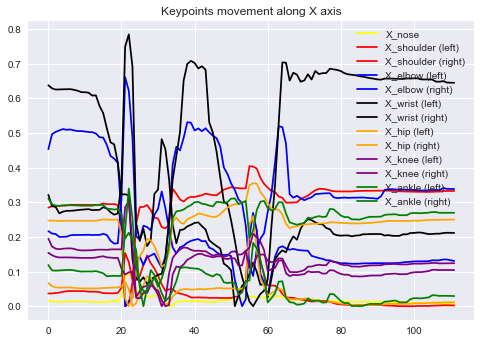

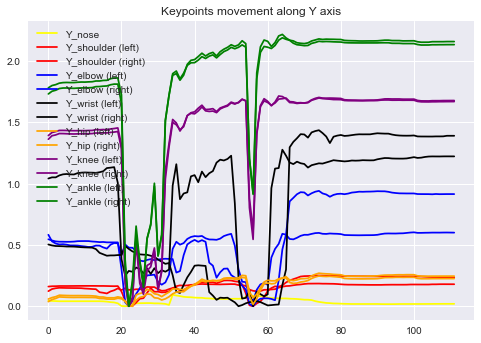

In [84]:
show_plot()

